<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/inner_join_fundamentals_and_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Kernel setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%capture
!pip install wandb
!git clone https://github.com/Krankile/npmf.git

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


##General setup

In [ ]:
%%capture
!cd npmf && git pull

import os
from collections import defaultdict
from collections import Counter
from datetime import datetime
from operator import itemgetter

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import wandb as wb

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from npmf.utils.colors import main, main2, main3
from npmf.utils.wandb import get_dataset, get_datasets, put_dataset, update_aliases
from npmf.utils.eikon import column_mapping 

In [ ]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (6, 4)  # (6, 4) is default and used in the paper

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
np.random.seed(420)

# Data processing

## Collect data from stock and fundamental and find intersection of unique tickers

In [ ]:
stock_df = get_dataset("stock-data:v2", "master")
fundamental_df = get_dataset("fundamental-data:v1", "master")
meta_df = get_dataset("meta-data:v1", "master").drop(columns=["index"])

wandb: Currently logged in as: kjartan (krankile). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact stock-data:v2, 434.28MB. 1 files... Done. 0:0:0


## We start by seeing the amount of data we have before joining the stock and fundamental data

In [ ]:
stock_na = stock_df.market_cap.isna()

In [ ]:
len(stock_df.ticker.unique())

5213

In [ ]:
fundamental_df.ticker.unique()

<StringArray>
[  'OMVV.VI',     'MUR.N',     'NBR.N',    'OIL.CD', '600256.SS', '600248.SS',
    'AGE.BK',     'CEI.A',  'NESTE.HE',  'OANDO.LG',
 ...
   'MCPH.PK',   'CFFI.OQ',   'VBFC.OQ',   'MOFG.OQ',   'KBNK.NS',   'CRDI.MI',
    '8359.T',   'CIEB.CA',   'AMMB.KL',  'QNBFL.IS']
Length: 3179, dtype: string

In [ ]:
fundamental_without_copies = fundamental_df.loc[:,:"short_term_debt_p_assets"]

print("\t   ----STOCK----")

print(f"stock entries left: {stock_df.shape[0]:,}")

print("\n\t----FUNDAMENTALS----")
print(f"datapoints in rapports left: {fundamental_without_copies.count(axis=0, numeric_only=True).sum():,}")
print(f"quarterly rapports left: {fundamental_without_copies.shape[0]:,}")
print(f"average entries per rapports left: {fundamental_without_copies.count(axis=0, numeric_only=True).sum()/fundamental_without_copies.shape[0]}") 

	   ----STOCK----
stock entries left: 18,085,295

	----FUNDAMENTALS----
datapoints in rapports left: 1,384,410
quarterly rapports left: 145,531
average entries per rapports left: 9.512818574736654


In [ ]:
unique_fundamental = set(fundamental_df.ticker.unique())
unique_stock = set(stock_df.ticker.unique())

full_data_companies = unique_fundamental & unique_stock

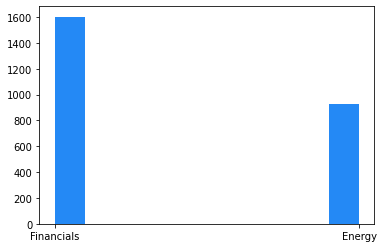

In [ ]:
 meta_df[meta_df.ticker.isin(full_data_companies)].economic_sector.hist(grid=False, color=main);

There are more banking services companies than there are energy. We want the selection to be 50/50 overall (will in reality be time dependent), and thus find the ~850 companies  

## Select the most data rich companies from the banking sector category

In [ ]:
oil_inner_joined = meta_df[(meta_df.ticker.isin(full_data_companies)) & (meta_df.economic_sector == "Energy")].ticker
banking_services_inner_joined = meta_df[(meta_df.ticker.isin(full_data_companies)) & (meta_df.industry_group == "Banking Services")].ticker

In [ ]:
banking_lst = []
for ticker, banking_df in fundamental_df[fundamental_df.ticker.isin(banking_services_inner_joined)].groupby(by="ticker"):
    banking_lst.append((ticker, banking_df.count(axis=0, numeric_only=True).sum()))

sorted_by_non_na_count = sorted(banking_lst, key=lambda tup: tup[1])

679


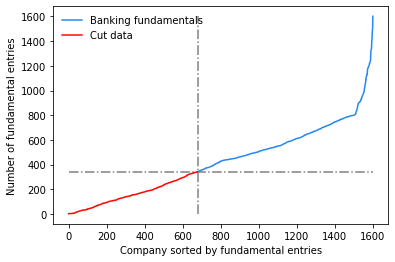

In [ ]:
banking_services_sorted = list(list(zip(*sorted_by_non_na_count))[0])
entries = list(list(zip(*sorted_by_non_na_count))[1])

cutoff_idex = len(banking_services_sorted) - len(oil_inner_joined)
print(cutoff_idex)
cutoff_entries = entries[:cutoff_idex] + [None]*(len(banking_services_sorted)-cutoff_idex)
kept_entries = [None]*(cutoff_idex) + entries[cutoff_idex:] 

plt.vlines(cutoff_idex, 0, max(entries), color="grey", linestyle="-.")
plt.hlines(entries[cutoff_idex], 0, len(banking_services_sorted), color="grey", linestyle="-.")

plt.ylabel("Number of fundamental entries")
plt.xlabel("Company sorted by fundamental entries")

plt.plot([i for i in range(len(banking_services_sorted))], kept_entries, label="Banking fundamentals")
plt.plot([i for i in range(len(banking_services_sorted))], cutoff_entries, label="Cut data")
plt.legend(frameon=False);

In [ ]:
signal_rich_banking = banking_services_sorted[cutoff_idex:]

if len(signal_rich_banking) == len(oil_inner_joined):
    print(f"Hurray now we have matching length of data with {len(oil_inner_joined)} companies of each sector") 

Hurray now we have matching length of data with 923 companies of each sector


In [ ]:
banking_oil_equal_tickers = full_data_companies & (set(signal_rich_banking) | set(oil_inner_joined.to_list()) )

## Inspect the raw data

To know what we're working with

In [ ]:
fundamental_df = fundamental_df.rename(columns=column_mapping).astype({"announce_date":"datetime64[ns]"})
meta_df = meta_df.rename(columns=column_mapping)

full_data_fundamentals = fundamental_df[fundamental_df["ticker"].isin(banking_oil_equal_tickers)]
full_data_stock = stock_df[stock_df["ticker"].isin(banking_oil_equal_tickers)]
full_data_meta = meta_df[meta_df["ticker"].isin(banking_oil_equal_tickers)]

In [ ]:
full_data_fundamentals = full_data_fundamentals.iloc[:,1:] 

In [ ]:
(
    full_data_stock.shape[0],
    full_data_fundamentals.count(axis=0, numeric_only=True).sum(),
    full_data_meta.count(axis=0, numeric_only=True).sum(),
)

(7474182, 1141603, 1773)

In [ ]:
inner_joined_without_augmentation = full_data_fundamentals.loc[:,:"short_term_debt_p_assets"]

In [ ]:
print("\t   ----STOCK----")
print(f"stock in entries left: {full_data_stock.shape[0]:,}")

print("\n\t----FUNDAMENTALS----")
print(f"datapoints in rapports left: {inner_joined_without_augmentation.count(axis=0, numeric_only=True).sum():,}")
print(f"quarterly rapports left: {inner_joined_without_augmentation.shape[0]:,}")
print(f"average entries per rapports left: {inner_joined_without_augmentation.count(axis=0, numeric_only=True).sum()/full_data_fundamentals.shape[0]}") 

	   ----STOCK----
stock in entries left: 7,474,182

	----FUNDAMENTALS----
datapoints in rapports left: 917,887
quarterly rapports left: 104,178
average entries per rapports left: 8.810756589683043


In [ ]:
full_data_fundamentals[(full_data_fundamentals.duplicated(subset=['ticker','announce_date', "date"] , keep=False))]
forward_filled_df = pd.DataFrame(columns=full_data_fundamentals.columns) 

for ric in tqdm(full_data_fundamentals["ticker"].unique()):
    forward_filled_df = pd.concat( [forward_filled_df, full_data_fundamentals[full_data_fundamentals["ticker"] == ric].ffill(axis = 0)], axis=0)

100%|██████████| 1846/1846 [00:31<00:00, 58.02it/s]


In [ ]:
print("\t   ----STOCK----")
print(f"stock in entries left: {full_data_stock.shape[0]:,}")
print(f"stock values na: {full_data_stock.market_cap.isna().sum().sum():,}")

print("\n\t----FUNDAMENTALS----")
print(f"datapoints in rapports left: {forward_filled_df.count(axis=0, numeric_only=True).sum():,}")
print(f"quarterly rapports left: {forward_filled_df.shape[0]:,}")
print(f"average entries per rapports left: {forward_filled_df.count(axis=0, numeric_only=True).sum()/forward_filled_df.shape[0]}") 

	   ----STOCK----
stock in entries left: 7,474,182
stock values na: 8

	----FUNDAMENTALS----
datapoints in rapports left: 1,206,983
quarterly rapports left: 104,178
average entries per rapports left: 11.58577626754209


Wow! After this rather strict datacleaning process we have 14.9m day closing prices for 1846 companies, 

## Upload full data to WandB

In [ ]:
bogus_stock_entries = full_data_stock[(full_data_stock.groupby(by="ticker").market_cap.pct_change() > 10)  | (full_data_stock.groupby(by="ticker").market_cap.pct_change() < -.99)].ticker.unique()
full_data_stock = full_data_stock[~full_data_stock.ticker.isin(bogus_stock_entries)] 

In [ ]:
full_data_stock = full_data_stock[~full_data_stock.market_cap.isnull()] 
legal_tickers = full_data_stock.ticker 

In [ ]:
none_dates = forward_filled_df.date.isnull()
forward_filled_df.loc[none_dates,"date"] = forward_filled_df.loc[none_dates, "announce_date"]  
forward_filled_df["date"] = forward_filled_df["date"].astype(np.datetime64,) 



(104178, 21)
(103201, 21)


In [ ]:
forward_filled_df = forward_filled_df[forward_filled_df["ticker"].isin(legal_tickers)]
full_data_meta = full_data_meta[full_data_meta["ticker"].isin(legal_tickers)]

forward_filled_df = forward_filled_df[(forward_filled_df.total_assets != 0) | (forward_filled_df.total_assets.isna())]

In [ ]:
print("\t   ----STOCK----")
print(f"stock entries left: {full_data_stock.shape[0]:,}")
print(f"stock values na: {full_data_stock.market_cap.isna().sum().sum():,}")

print("\n\t----FUNDAMENTALS----")
print(f"datapoints in rapports left: {forward_filled_df.count(axis=0, numeric_only=True).sum():,}")
print(f"quarterly rapports left: {forward_filled_df.shape[0]:,}")
print(f"average entries per rapports left: {forward_filled_df.count(axis=0, numeric_only=True).sum()/forward_filled_df.shape[0]}") 

	   ----STOCK----
stock entries left: 6,969,379
stock values na: 0

	----FUNDAMENTALS----
datapoints in rapports left: 1,122,395
quarterly rapports left: 97,266
average entries per rapports left: 11.539438241523246


In [ ]:
forward_filled_df

,ticker,date,period_end_date,announce_date,revenue,gross_profit,ebitda,ebit,net_income,fcf,...,total_current_assets,total_liabilites,total_current_liabilities,long_term_debt_p_assets,short_term_debt_p_assets,gross_profit_p_revenue,ebitda_p_revenue,ebit_p_revenue,net_income_p_revenue,fcf_p_revenue
0,OMVV.VI,2000-06-30T00:00:00Z,2000-06-30,2000-10-23,1591395023.28372,230190745.555143,181045434.200878,105530002.190288,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.144647,0.113765,0.066313,NaN,NaN
1,OMVV.VI,2000-12-31T00:00:00Z,2000-12-31,2001-04-30,1938098647.94837,372273990.672257,228378009.139304,132398360.578508,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.192082,0.117836,0.068314,NaN,NaN
2,OMVV.VI,2001-03-31T00:00:00Z,2001-03-31,2001-11-15,1675754784.0278,270127135.374168,246253937.336036,174937923.894256,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.161197,0.146951,0.104394,NaN,NaN
3,OMVV.VI,2001-06-30T00:00:00Z,2001-06-30,2001-11-15,1704178457.61632,261593371.574251,199438283.407691,139758657.318887,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.153501,0.117029,0.082009,NaN,NaN
4,OMVV.VI,2001-09-30T00:00:00Z,2001-09-30,2001-11-08,1692966706.46458,247021992.14371,223213423.136865,133206040.77615,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.145911,0.131847,0.078682,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145362,QNBFL.IS,2020-12-31T00:00:00Z,2020-12-31,2021-01-27,22561625.40366,23938961.038961,19901776.103337,19684876.210979,4358783.68047,-55370641.251227,...,976299863.343528,914465419.806243,0.0,79.43442,16.24148,1.000000,0.882107,0.872494,0.193195,-2.454196
145363,QNBFL.IS,2021-03-31T00:00:00Z,2021-03-31,2021-04-27,22040660.367059,23938961.038961,19429517.582697,19229733.499921,5300725.873309,2229011.378327,...,976299863.343528,883333373.76727,0.0,78.55885,16.24148,1.000000,0.881531,0.872466,0.240498,0.101132
145364,QNBFL.IS,2021-06-30T00:00:00Z,2021-06-30,2021-07-28,22471477.647437,23938961.038961,19866148.879212,19660604.110895,5087399.819672,-19495675.682312,...,976299863.343528,890567919.390604,0.0,46.78473,23.34352,1.000000,0.884061,0.874914,0.226394,-0.867574
145365,QNBFL.IS,2021-09-30T00:00:00Z,2021-09-30,2021-10-26,23414395.354595,23938961.038961,20764106.142108,20558956.584367,5429177.975195,-11886504.625681,...,976299863.343528,956602934.887804,0.0,57.43615,17.6007,1.000000,0.886809,0.878048,0.231874,-0.507658


In [ ]:
upload_fundamental = True
upload_stock = False
upload_meta = False

if upload_fundamental:
    put_dataset(forward_filled_df, filename="fundamental-data.feather", project="master")

if upload_stock: 
    put_dataset(full_data_stock, filename="stock-data.feather", project="master")

if upload_meta: 
    put_dataset(full_data_meta, filename="meta-data.feather", project="master")

## Now add some aliases to recognize the version 

In [ ]:
update_alias = True
project = "master"
alias = "final"
artifacts = ["fundamental-data:v6"]#["fundamental-data:","meta-data:", "stock-data:"]

if update_alias:
    update_aliases(project=project, alias=alias, artifacts=artifacts)

In [ ]:
fund_df, stock_df, meta_df, macro_df = get_datasets(["fundamental-data:final","stock-data:final","meta-data:final", "macro-data:final"], project="master")

wandb: Currently logged in as: kjartan (krankile). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact stock-data:final, 178.18MB. 1 files... Done. 0:0:0
